# Deep Learning for Painter Classification

### Part A: Basic Explorations & Data Loading

The dataset used is painter-by-numbers, obtained [here](https://www.kaggle.com/c/painter-by-numbers/data). The competition was designed for a pairwise comparison scheme in order to be applied in forgery recognition, however we are going to be using the data to design a classifier that performs painter recognition, for 20 different artists.

The data is available in the `train.zip` and `test.zip` folders and all the relevant information is located in `all_data_info.csv`. Since we are not designing a model for this specific competition, we may retrieve all of the data (both train and test) and then decide what to do with them. Let us first load the `all_data_info.csv` file in order to investigate it further.

In [1]:
# All the relevant modules and libraries
import itertools
import zipfile
import re

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import cv2
from PIL import Image
from skimage.feature import hog

from sklearn import preprocessing
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import SubsetRandomSampler, DataLoader
from torchvision import transforms, models

path = '../input/painter-by-numbers/'

df = pd.read_csv(path+'all_data_info.csv')
df.head()

,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,Barnett Newman,1955.0,abstract,15530.0,6911.0,9201912.0,wikiart,Color Field Painting,Uriel,train_only,True,102257.jpg
1,Barnett Newman,1950.0,abstract,14559.0,6866.0,8867532.0,wikiart,Color Field Painting,Vir Heroicus Sublimis,train_only,True,75232.jpg
2,kiri nichol,2013.0,NaN,9003.0,9004.0,1756681.0,NaN,Neoplasticism,NaN,test_only,False,32145.jpg
3,kiri nichol,2013.0,NaN,9003.0,9004.0,1942046.0,NaN,Neoplasticism,NaN,test_only,False,20304.jpg
4,kiri nichol,2013.0,NaN,9003.0,9004.0,1526212.0,NaN,Neoplasticism,NaN,test_only,False,836.jpg


Some basic exploratory tasks follow. Our task is to find data for 20 artists, so we will need 20 artists for whom there is enough data for training. Furthermore, we need a balanced dataset, so we will have to base our sample-per-painter size on the artists with the least paintings.

In [2]:
print(f"The full dataset contains a total of {len(df['artist'].unique())} different artists and {len(df['genre'].unique())} unique painting genres.\n")
ash = 5
print(f"The {ash} artists with the most paintings available in the dataset are:")
df['artist'].value_counts().head(ash)

The full dataset contains a total of 2319 different artists and 43 unique painting genres.

The 5 artists with the most paintings available in the dataset are:


Ivan Aivazovsky          500
John Singer Sargent      500
Pierre-Auguste Renoir    500
Marc Chagall             500
Pablo Picasso            500
Name: artist, dtype: int64

It appears that the most paintings per artist available are 500. Before proceeding, we need to remove the corrupted datafiles from the dataset.

In [3]:
# This cell creates a list of the corrupted files' IDs, in order to ensure
# that we don't use any of them in our dataset.
file_path = '../input/painter-by-numbers/'

archive = zipfile.ZipFile(file_path+'replacements_for_corrupted_files.zip', 'r')
corrupted_ids = set()

for item in archive.namelist():
    ID = re.sub("[^0-9]", "", item)
    if ID != "":
        corrupted_ids.add(ID)

drop_idx = []
for index, row in df.iterrows():
    id_check = re.sub("[^0-9]", "", row['new_filename'])
    if id_check in corrupted_ids:
        drop_idx.append(index)
        
df = df.drop(drop_idx)

Now, we may construct a list of artists we're interested in classifying and check:
1. If they have available work in this dataset
2. If the corresponding sample is large enough for training and testing

In [4]:
painter_dict = {'Kandinsky':'','Dali':'','Picasso':'','Delacroix':'','Rembrandt':'','Gogh':'',
               'Kuniyoshi':'','Dore':'','Steinlen':'','Saryan':'','Goya':'','Lautrec':'',
               'Modigliani':'','Beksinski':'','Pissarro':'','Kirchner':'','Renoir':'','Piranesi':'',
               'Degas':'','Chagall':''}

paintings_dict = painter_dict.copy()

# Find the correspondence between our names and the names in the dataframe
# Also count the number of paintings
for artist in painter_dict:
    for painter in df['artist']:
        if artist in painter:
            painter_dict[artist] = painter
            paintings = df[df['artist'] == painter].shape[0]
            paintings_dict[artist] = paintings
            break

for artist in painter_dict:
    print(f'The artist named {painter_dict[artist]} has a total of {paintings_dict[artist]} paintings in this dataset.')

sample_size = min(paintings_dict.values())
min_a = list(paintings_dict.keys())[list(paintings_dict.values()).index(sample_size)]
print(f'\nThe artist with the smallest number of paintings is {min_a} with {sample_size} paintings.')

The artist named  Wassily Kandinsky has a total of 214 paintings in this dataset.
The artist named Salvador Dali has a total of 485 paintings in this dataset.
The artist named Pablo Picasso has a total of 500 paintings in this dataset.
The artist named Eugene Delacroix has a total of 221 paintings in this dataset.
The artist named Rembrandt has a total of 500 paintings in this dataset.
The artist named Vincent van Gogh has a total of 494 paintings in this dataset.
The artist named Utagawa Kuniyoshi has a total of 347 paintings in this dataset.
The artist named Gustave Dore has a total of 500 paintings in this dataset.
The artist named Theophile Steinlen has a total of 485 paintings in this dataset.
The artist named Martiros Saryan has a total of 499 paintings in this dataset.
The artist named Francisco Goya has a total of 386 paintings in this dataset.
The artist named Henri de Toulouse-Lautrec has a total of 369 paintings in this dataset.
The artist named Amedeo Modigliani has a total

It therefore seems that, if we're not interested in generating new paintings from the existing ones, we will be using a sub-dataset containing 214 paintings per artist (so that it is balanced), with a total of 4280 paintings.

Note that, alternatively, one may decide to keep the 20 artists with the most paintings, instead of handpicking them, even though the latter is more fun. For example, Kandinsky is the third writer's favourite painter, so this is why the dataset is limited to 214 samples per artist. However, this also helps speed up the training process, since it is a good enough sample number. In the *boring* case, the following code suffices:

```
paintings = df['artist'].value_counts().head(20)
artists = paintings.index.tolist()
sample_size = min(paintings)
```

and then, in the next cell, use `for artist in artists:`.

In [5]:
active_df = pd.DataFrame({}) # Reduce the large dataframe into the one containing only relevant data

#for artist in artists: # <- use this in the boring case
for artist in painter_dict.values(): # <- use this in the non boring case
    # small size = not many pixels = good (the reduction won't be as bad (?))
    # if the opposite is true, set ascending = [False,False]
    # or remove the contraint alltogether
    #tr_df = df[(df['artist']==artist)].sort_values(by=['in_train'], ascending=[False])
    tr_df = df[(df['artist']==artist)].sort_values(by=['in_train','size_bytes'], ascending=[False, True])
    active_df = pd.concat([active_df,tr_df.iloc[:sample_size]])

At the moment, `active_df` contains 4280 rows, where each row is a datum to be used for the model's training and evaluation. The next part of this preprocessing phase is to load only the relevant data, i.e. the elements of `active_df['new_filename']`, properly transform it and create the dataset that will be used.

First, we create a LabelEncoder to transform artist names into integers.

In [6]:
artists = list(painter_dict.values())

# Label Encoder to transform artist names into integers from 0 to 19
LabEnc = preprocessing.LabelEncoder()
LabEnc.fit(artists)

LabelEncoder()

Next, we create a transformer function that receives images, processes them and transforms them into tensors. Note that this transformer function is required for the training of "classic" classifiers as well, apart from CNNs. However, it's name ends with `_nn` simply because it corresponds to *all* the transformations required for the case of CNNs, while the classic classifiers require further modifications.

This is the original image:



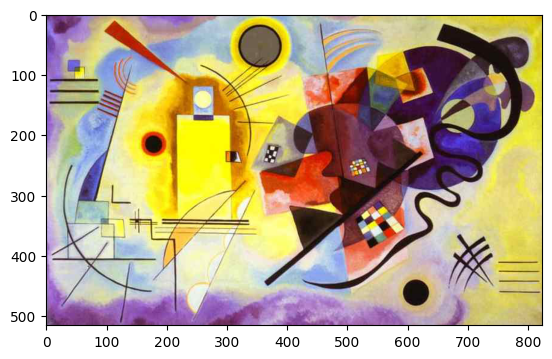

This is the cropped part of the transformed image:



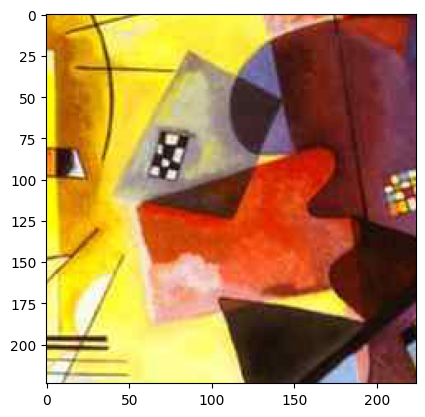

This is the transformed, resized image:



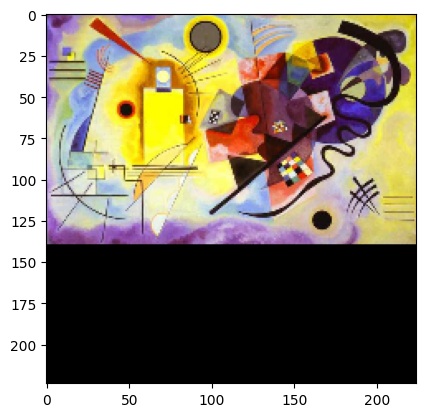

Transformed and resized, but with normalization as well:



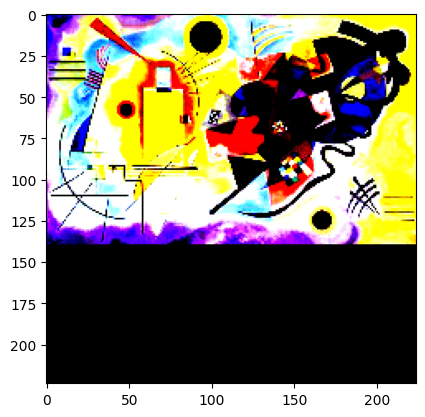

In [7]:
matplotlib.rc_file_defaults()

def image_transformer_nn(image, apply_norm=True, crop_img=True, new_dim=224):
    """
    Args:
        resize_num (int):
            Dimension (pixels) to resize image
        apply_norm (bool):
            Choose whether to apply the normalization or not
        crop_img (bool):
            Choose whether to resize the image into the new_dim size, or crop
            a square from its center, sized new_dim x new_dim
    """
    if crop_img:
        cropper = transforms.CenterCrop(new_dim)
        image = cropper(image)
    # Using transforms.Compose() is another option to perform these sequentially, but
    # let's keep it like this until we find the "final" transformations sequence
    tensoring = transforms.ToTensor()
    image = tensoring(image) # shape is now (channels, height, width), see next line
    channels, height, width = image.shape
    
    # This check was added because some images are automatically loaded as grayscale
    if image.shape[0] < 3:
        image = image.expand(3, -1, -1)
    # This check is for images like 18807 that have extra channels with zero information
    if image.shape[0] > 3:
        image = image[0:3,:,:]
    
    # This is the imagenet normalizer, maybe define our own?
    if apply_norm:
        normalizer = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        image = normalizer(image)
    
    if not crop_img:
        if width < height:
            # Convolutions are invariant to rotations, so we choose to pad everything
            # "down". This means that for landscape images (width > height) no rotation
            # needs to be performed we just pad "down". For vertical images (width < height),
            # in order to perform the "down" padding we have to rotate them first.
            image = image.transpose(1,2)
        channels, height, width = image.shape
        res_percent = float(new_dim/width) # done to keep aspect ratio, width is max dim
        height = round(height*res_percent)
        resizer = transforms.Resize((height,new_dim))
        image = resizer(image)
        # Now that the image is resized by keeping aspect ratio, we pad "down"
        padder = transforms.Pad([0,0,0,int(new_dim-height)])
        image = padder(image)
        
    return image

# Example:
archive = zipfile.ZipFile(file_path+'train.zip', 'r')
img_path = 'train/'
imgdata = archive.open(img_path+'69382.jpg')
image = Image.open(imgdata)

print("This is the original image:\n")
plt.imshow(image)
plt.show()

print("This is the cropped part of the transformed image:\n")
image2 = image_transformer_nn(image, apply_norm=False, crop_img=True, new_dim=224)
plt.imshow(image2.numpy().transpose(1,2,0))
plt.show()

print("This is the transformed, resized image:\n")
image3a = image_transformer_nn(image, apply_norm=False, crop_img=False, new_dim=224)
plt.imshow(image3a.numpy().transpose(1,2,0))
plt.show()

print("Transformed and resized, but with normalization as well:\n")
image3b = image_transformer_nn(image, apply_norm=True, crop_img=False, new_dim=224)
plt.imshow(image3b.numpy().transpose(1,2,0))
plt.show()

Two options are given: either perform resizing by respecting aspect ratio and then pad the data to apply the convolutional filters, or avoid padding alltogether and simply resize into squares via cropping square parts of the image. The former is usually preferred.

The next part corresponds to the collection of the data. This collection is done separately for data used for CNNs and data used for other classifiers.

The class seen below is a Dataset type class, that constructs the Dataset to be used for the CNNs training and evaluation.

In [8]:
# Creating one such class object currently requires 5-6 minutes of runtime.

import torch
from torch.utils.data import Dataset

# For Neural Networks
class ImageDataset(Dataset):
    def __init__(self, path, dataframe, lab_encoder, img_size=224, normalize=True, crop=False):
        """
        Args:
            path (string):
                Where to look for the files to extract
            dataframe (pd.DataFrame):
                dataframe to use for the IDs
            lab_encoder:
                label encoder to transform artist names into integers
            img_size (int):
                size to be used
            normalize (bool):
                perform normalization during transformation or not
            crop (bool):
                True: crop only a center from the image
                False: Resize image with respect to aspect ratio and pad
        """
        self.encoder = lab_encoder
        self.img_size = img_size
        self.normalize = normalize
        self.crop = crop
        self.feats, self.labels = self.get_all_items(path,dataframe)
        
    def get_all_items(self,path,dataframe):

        # We begin with the train.zip
        curr_df = dataframe[dataframe['in_train']==True]
        archive = zipfile.ZipFile(path+'train.zip', 'r')
        img_path = 'train/'

        feats = []
        labels = []

        for index, row in curr_df.iterrows():
            # Features
            file = row['new_filename']
            imgdata = archive.open(img_path+file)
            try:
                image = Image.open(imgdata)
                datum = image_transformer_nn(image, apply_norm=self.normalize, 
                                          crop_img=self.crop, new_dim=self.img_size)
                feats.append(datum)

                # Label
                artist = row['artist']
                label = self.encoder.transform([artist])[0]
                labels.append(label)
            except Image.DecompressionBombError:
                print(f"Skipped loading image {file} to avoid a DecompressionBombError.")

        # Same for the test.zip
        curr_df = dataframe[dataframe['in_train']==False]
        archive = zipfile.ZipFile(path+'test.zip', 'r')
        img_path = 'test/'

        for index, row in curr_df.iterrows():
            # Features
            file = row['new_filename']
            imgdata = archive.open(img_path+file)
            try:
                image = Image.open(imgdata)
                datum = image_transformer_nn(image, apply_norm=self.normalize, 
                                          crop_img=self.crop, new_dim=self.img_size)
                feats.append(datum)

                # Label
                artist = row['artist']
                label = self.encoder.transform([artist])[0]
                labels.append(label)
            except Image.DecompressionBombError:
                print(f"Skipped loading image {file} to avoid a DecompressionBombError.")

        feats = torch.stack(feats)
        labels = torch.LongTensor(labels)
        return feats, labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        return self.feats[item], self.labels[item]

On the other hand, the following function creates a tuple of the type (X, y) with data to be used in classic classifiers. The features used here are not the pictures themselves (unlike in the case of CNNs), but HOG or SIFT type features (these are two built-in options, however they can be expanded).

In [9]:
# For other models
def ImageData(path, dataframe, lab_encoder, hog_mode, sift_mode, img_size=224):

    # We begin with the train.zip
    curr_df = dataframe[dataframe['in_train']==True]
    archive = zipfile.ZipFile(path+'train.zip', 'r')
    img_path = 'train/'

    PaintFeats = []
    PaintLabels = []

    for index, row in curr_df.iterrows():
        # Features
        file = row['new_filename']
        imgdata = archive.open(img_path+file)
        try:
            image = Image.open(imgdata)
            datum = image_transformer_nn(image, apply_norm=False, crop_img=False, new_dim=img_size)
            
            # Up to that point, the output was the same as in the NN case
            np_datum = datum.numpy().transpose(1,2,0)
            
            if hog_mode:
                orients, ppc, cpb = hog_mode[0], hog_mode[1], hog_mode[2]
                # orients = number of grad orientations, default = 9
                # ppc = pixels per cell, default = (8,8)
                # cpb = cells per block, default = (2,2)
                datum = hog(np_datum, orientations=orients, pixels_per_cell=ppc,
                            cells_per_block=cpb, feature_vector=True, channel_axis=2)
                PaintFeats.append(datum)
                
            elif sift_mode:
                np_datum = cv2.normalize(np_datum, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
                imgtogray = cv2.cvtColor(np_datum, cv2.COLOR_BGR2GRAY)
                PaintFeats.append(imgtogray)
    
            # Label
            artist = row['artist']
            label = lab_encoder.transform([artist])[0]
            PaintLabels.append(label)
        except Image.DecompressionBombError:
            print(f"Skipped loading image {file} to avoid a DecompressionBombError.")

    # Same for the test.zip
    curr_df = dataframe[dataframe['in_train']==False]
    archive = zipfile.ZipFile(path+'test.zip', 'r')
    img_path = 'test/'

    for index, row in curr_df.iterrows():
        # Features
        file = row['new_filename']
        imgdata = archive.open(img_path+file)
        try:
            image = Image.open(imgdata)
            datum = image_transformer_nn(image, apply_norm=False, crop_img=False, new_dim=img_size)
            
            # Up to that point, the output was the same as in the NN case
            np_datum = datum.numpy().transpose(1,2,0)
            
            if hog_mode:
                orients, ppc, cpb = hog_mode[0], hog_mode[1], hog_mode[2]
                # orients = number of grad orientations, default = 9
                # ppc = pixels per cell, default = (8,8)
                # cpb = cells per block, default = (2,2)
                datum = hog(np_datum, orientations=orients, pixels_per_cell=ppc,
                            cells_per_block=cpb, feature_vector=True, channel_axis=2)
                PaintFeats.append(datum)
                
            elif sift_mode:
                np_datum = cv2.normalize(np_datum, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
                imgtogray = cv2.cvtColor(np_datum, cv2.COLOR_BGR2GRAY)
                PaintFeats.append(imgtogray)
            
            # Label
            artist = row['artist']
            label = lab_encoder.transform([artist])[0]
            PaintLabels.append(label) # datum is a tensor by default
        except Image.DecompressionBombError:
            print(f"Skipped loading image {file} to avoid a DecompressionBombError.")
    
    return np.asarray(PaintFeats), np.asarray(PaintLabels)

At this point, the data can be loaded either in the form of a pytorch Dataset via

```
nn_data = ImageDataset(file_path, active_df, LabEnc, img_size=224, resize_aspect=False)
```

for example, or in the form of two numpy arrays (the traditional X and y), via

```
X, y = ImageData(path, dataframe, lab_encoder, hog_mode, sift_mode, img_size=224)
```

What is left to conclude this first part is the construction of proper splits for the data and the corresponding DataLoaders in the case of NN models. This is done through the function defined below, which is common for both types of data.

In [10]:
# This cell splits data into train-val-test and creates DataLoaders in the case of NNs
def DataSplitter(data, ratios=[60,20,20], need_val=True, batches=None, shuffle=True, seed=None):
    """
    Args:
        data (Dataset or List):
            In the case of NN, it's the dataset to be loaded into loaders. In the case
            of other models, it's a list containing the Features and Labels lists
        batches (int):
            batch size for loaders in case of NN
        ratios (list):
            list of integers, containing the ratios [train,val,test] for splitting
            example: [60,25,15] means 60% train data, 25% val data and 15% test data
        shuffle (bool):
            option to shuffle data
        seed (None or int):
            seed for shuffling
    """
    first_ratio = (ratios[1]+ratios[2])/sum(ratios)
    second_ratio = ratios[2]/(ratios[1]+ratios[2])
    
    if isinstance(data,ImageDataset): # NN case
        
        labels = data.labels.numpy()
        
        train_indices, rest_indices = train_test_split(np.arange(len(labels)),
                                               test_size=first_ratio, shuffle=shuffle,
                                               random_state=seed, stratify=labels)
        
        rest_labels = data[rest_indices][1]
        
        val_indices, test_indices = train_test_split(rest_indices,
                                            test_size=second_ratio, shuffle=shuffle,
                                            random_state=seed, stratify=rest_labels)

        train_sampler = SubsetRandomSampler(train_indices)
        val_sampler = SubsetRandomSampler(val_indices)
        test_sampler = SubsetRandomSampler(test_indices)

        train_loader = DataLoader(data,batch_size=batches,sampler=train_sampler)
        val_loader = DataLoader(data,batch_size=batches,sampler=val_sampler)
        test_loader = DataLoader(data,batch_size=batches,sampler=test_sampler)
        
        return train_loader, val_loader, test_loader
        
    elif isinstance(data,tuple): # other model case
        X_train, X_rest, y_train, y_rest = train_test_split(data[0], data[1],
                                                            test_size=first_ratio,
                                                            shuffle=shuffle,
                                                            random_state=seed,
                                                            stratify=data[1])
        if need_val:
            X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest,
                                                            test_size=second_ratio,
                                                            shuffle=shuffle, random_state=seed,
                                                            stratify=y_rest)
        
            return X_train, X_val, X_test, y_train, y_val, y_test
        return X_train, X_rest, y_train, y_rest
    else:
        print('Invalid data Type. Either insert Dataset to create DataLoaders or a list of two numpy arrays to perform the splitting.')
        return

### Auxiliary Functions

We leave some auxiliary functions here, for uniformity in graphs.

In [11]:
sns.set(style = "darkgrid") # Personal preference

def CustomCmap(from_rgb,to_rgb):

    # from color r,g,b
    r1,g1,b1 = from_rgb

    # to color r,g,b
    r2,g2,b2 = to_rgb

    cdict = {'red': ((0, r1, r1),
                   (1, r2, r2)),
           'green': ((0, g1, g1),
                    (1, g2, g2)),
           'blue': ((0, b1, b1),
                   (1, b2, b2))}

    cmap = LinearSegmentedColormap('custom_cmap', cdict)
    return cmap

mycmap = CustomCmap([1.0, 1.0, 1.0], [72/255, 99/255, 147/255])
mycmap_r = CustomCmap([72/255, 99/255, 147/255], [1.0, 1.0, 1.0])

mycol = (72/255, 99/255, 147/255)
mycomplcol = (129/255, 143/255, 163/255)

def plot_cm(cfmatrix,title,classes):
    fig, ax1 = plt.subplots(1,1) #, figsize=(5,5)

    for ax,cm in zip([ax1],[cfmatrix]):
        im = ax.imshow(cm, interpolation='nearest', cmap=mycmap)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=.2)
        plt.colorbar(im, cax=cax) #, ticks=[-1,-0.5,0,0.5,1]
        ax.set_title(title,fontsize=14)
        tick_marks = np.arange(len(classes))
        ax.set_xticks(tick_marks)
        ax.set_xticklabels(classes, rotation=90)
        ax.set_yticks(tick_marks)
        ax.set_yticklabels(classes)

        fmt = 'd'
        thresh = cm.max() / 2.

        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            ax.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

        ax.set_ylabel('True label',fontsize=14)
        ax.set_xlabel('Predicted label',fontsize=14)

    plt.savefig(title+'.pdf', bbox_inches='tight')
    plt.show()

### Part B: Neural Networks Training

With the DataLoaders at hand, we may proceed to the NN training process. A first attempt is to define a new CNN Class and try to evaluate its performance on the data.

In [12]:
%%time
# Load the Dataset for NN training
nn_data = ImageDataset(file_path, active_df, LabEnc, img_size=224, normalize=True, crop=False)

Skipped loading image 95010.jpg to avoid a DecompressionBombError.
CPU times: user 2min 52s, sys: 54.2 s, total: 3min 46s
Wall time: 5min 17s


In [13]:
# Create Data Loaders for NN training
train_loader, val_loader, test_loader = DataSplitter(nn_data, ratios=[60,25,15], need_val=True, batches=32, shuffle=True, seed=420)

In [14]:
class CNNBackbone(nn.Module):
    def __init__(self, input_height, input_width, conv_channels, kernels, maxpools, lin_channels, dropout, batchnorm):
        """
        Agrs:
            input_height (int):
                image height in pixels
            input_width (int):
                image width in pixels
            conv_channels (list):
                contains the input and output channels for each
                convolutional layer, therefore using a total of
                len(channels)-1 convolutional layers
            kernels (list):
                contains the kernel sizes to be considered per
                convolution. Must have length len(channels)-1
            maxpools (list):
                contains the MaxPool2d kernel sizes to be considered
                per convolution. Must have length len(channels)-1
            lin_channels (list):
                contains the output channels for each linear layer
                following the convolutions, therefore using a total of
                len(lin_channels) linear layers.
                Note that the last element must be equal to the number
                of classes to be determined.
            classes (int):
                number of output features
            dropout (float):
                dropout probability, 0 <= dropout <= 1
            batchnorm (bool):
                boolean parameter to control whether batch normalization
                is applied or not.
        """
        super(CNNBackbone, self).__init__()
        self.num_conv_layers = len(kernels)
        self.batchnorm = batchnorm
        
        seq = []
        for i in range(self.num_conv_layers):
            seq.append(nn.Conv2d(in_channels=conv_channels[i], 
                                 out_channels=conv_channels[i+1],
                                 kernel_size=kernels[i], stride=1, padding=1))
            seq.append(nn.ReLU())
            if self.batchnorm:
                seq.append(nn.BatchNorm2d(num_features=conv_channels[i+1],track_running_stats=False))
            seq.append(nn.MaxPool2d(kernel_size=maxpools[i]))
            
        # Flatten the output of the final convolution layer
        seq.append(nn.Flatten())
        
        convolutions = nn.Sequential(*seq)
        
        # Calculation of first linear layer dimensions
        # We build an empty tensor of appropriate size and let him go through
        # the above sequence, in order to calculate the output's size automatically
        first_lin = convolutions(torch.empty(1,conv_channels[0],input_height,input_width)).size(-1)
        
        self.num_lin_layers = len(lin_channels)
        for i in range(self.num_lin_layers):
            if i == self.num_lin_layers-1:
                seq.append(nn.Linear(lin_channels[i-1], lin_channels[i]))
                break
            elif i == 0:
                seq.append(nn.Linear(first_lin, lin_channels[i]))
            else:
                seq.append(nn.Linear(lin_channels[i-1], lin_channels[i]))
            seq.append(nn.ReLU())
            seq.append(nn.Dropout(dropout))
        seq.append(nn.Softmax(1))
                
        self.fitter = nn.Sequential(*seq)

    def forward(self, x):
        """CNN forward
        Args:
            x (torch.Tensor):
                [B, S, F] Batch size x sequence length x feature size
                padded inputs
        Returns:
            torch.Tensor: [B, O] Batch size x CNN output size cnn outputs
        """
        out = self.fitter(x)
        return out
    
def load_backbone_from_checkpoint(model, checkpoint_path):
    model.load_state_dict(torch.load(checkpoint_path))
    
# adapted code from this repository: https://github.com/Bjarten/early-stopping-pytorch
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'Validation loss increase spotted. Early stopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

def training_loop(model, train_dataloader, optimizer, device="cuda"):
    model.train()
    batch_losses = []
            
    for batch in train_dataloader:
        x_batch, y_batch = batch
                
        # Move to device
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                
        # Clear the previous gradients first
        optimizer.zero_grad()
        
        # forward pass
        yhat = model(x_batch) # No unpacking occurs in CNNs
        
        # loss calculation
        loss = loss_function(yhat, y_batch)
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        batch_losses.append(loss.data.item())
        
    train_loss = np.mean(batch_losses)

    return train_loss


def validation_loop(model, val_dataloader, device="cuda"):
    
    model.eval()
    batch_losses = []
    
    for batch in val_dataloader:
        x_batch, y_batch = batch
                
        # Move to device
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        yhat = model(x_batch) # No unpacking occurs in CNNs
        
        loss = loss_function(yhat, y_batch)
        
        batch_losses.append(loss.data.item())
        
    val_loss = np.mean(batch_losses)

    return val_loss # Return validation_loss and anything else you need


def train(model, train_dataloader, val_dataloader, optimizer, epochs, device="cuda", patience=-1, verbose_ct=100):

    train_losses = []
    val_losses = []
    print(f"Initiating CNN training.")
    model_path = f'CNN.pt'
    checkpoint_path = 'checkpoint.pt'
        
    if patience != -1:
        early_stopping = EarlyStopping(patience=patience, verbose=False, path=checkpoint_path)

    for epoch in range(epochs):
        
        # Training loop
        train_loss = training_loop(model, train_dataloader, optimizer, device)    
        train_losses.append(train_loss)

        # Validation loop
        with torch.no_grad():

            val_loss = validation_loop(model, val_dataloader, device)
            val_losses.append(val_loss)

        if patience != -1:
            early_stopping(val_loss, model)

            if early_stopping.early_stop:
                print("Patience limit reached. Early stopping and going back to last checkpoint.")
                break

        if epoch % verbose_ct == 0:        
            print(f"[{epoch+1}/{epochs}] Training loss: {train_loss:.4f}\t Validation loss: {val_loss:.4f}.")

    if patience != -1 and early_stopping.early_stop == True:
        load_backbone_from_checkpoint(model,checkpoint_path)        

    torch.save(model.state_dict(), model_path)

    print(f"CNN training finished.\n")
    
    return train_losses, val_losses
    
def evaluate(model, test_dataloader, device="cuda"):
    model.eval()
    predictions = []
    labels = []
    
    with torch.no_grad():
        for batch in test_dataloader:
            
            x_batch, y_batch = batch
                
            # Move to device
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            
            yhat = model(x_batch) # No unpacking occurs in CNNs
            
            # Calculate the index of the maximum argument
            yhat_idx = torch.argmax(yhat, dim=1)
            
            predictions.append(yhat_idx.cpu().numpy())
            labels.append(y_batch.cpu().numpy())
    
    return predictions, labels  # Return the model predictions

# Small code to plot losses after training
def plot_losses(train_losses,val_losses,title):
    plt.plot(train_losses, label="Training loss", color=mycol)
    plt.plot(val_losses, label="Validation loss", color=mycomplcol)
    plt.legend(loc='best')
    plt.ylabel('Mean Loss')
    plt.xlabel('Epochs')
    plt.title(f"Loss graph during the process of training the CNN.")
    plt.savefig(title, bbox_inches='tight')
    plt.show() 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Initiating CNN training.
[1/2500] Training loss: 2.9798	 Validation loss: 2.9496.
[2/2500] Training loss: 2.9231	 Validation loss: 2.8864.
[3/2500] Training loss: 2.8638	 Validation loss: 2.8433.
[4/2500] Training loss: 2.8277	 Validation loss: 2.8135.
[5/2500] Training loss: 2.7982	 Validation loss: 2.7904.
[6/2500] Training loss: 2.7768	 Validation loss: 2.7753.
[7/2500] Training loss: 2.7599	 Validation loss: 2.7654.
[8/2500] Training loss: 2.7414	 Validation loss: 2.7536.
[9/2500] Training loss: 2.7241	 Validation loss: 2.7462.
[10/2500] Training loss: 2.7118	 Validation loss: 2.7356.
[11/2500] Training loss: 2.6930	 Validation loss: 2.7179.
[12/2500] Training loss: 2.6731	 Validation loss: 2.7099.
[13/2500] Training loss: 2.6539	 Validation loss: 2.7023.
[14/2500] Training loss: 2.6354	 Validation loss: 2.6944.
[15/2500] Training loss: 2.6166	 Validation loss: 2.6867.
[16/2500] Training loss: 2.5994	 Validation loss: 2.6843.
[17/2500] Training loss: 2.5835	 Validation loss: 2.6711

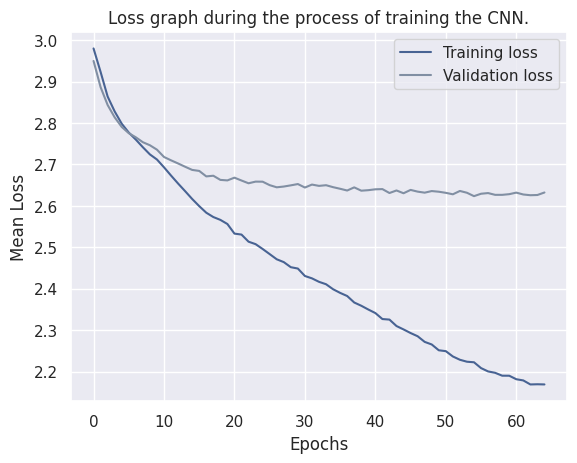

              precision    recall  f1-score   support

           0       0.55      0.38      0.44        32
           1       0.56      0.69      0.62        32
           2       0.63      0.53      0.58        32
           3       0.35      0.28      0.31        32
           4       0.53      0.50      0.52        32
           5       0.35      0.33      0.34        33
           6       0.51      0.62      0.56        32
           7       0.80      1.00      0.89        32
           8       0.87      0.84      0.86        32
           9       0.22      0.16      0.18        32
          10       0.22      0.16      0.18        32
          11       0.37      0.34      0.35        32
          12       0.27      0.31      0.29        32
          13       0.41      0.34      0.37        32
          14       0.44      0.56      0.49        32
          15       0.39      0.28      0.33        32
          16       0.59      0.73      0.65        33
          17       0.58    

In [15]:
%%time
input_height = nn_data[0][0].shape[1]
input_width = nn_data[0][0].shape[2]
conv_channels = [nn_data[0][0].shape[0],4,16,64,128]
kernels = [3,3,3,3]
maxpools = [2,2,2,2]
lin_channels = [256,128,20]
dropout = 0.25
learning_rate = 0.00001
weight_decay = 1e-6
patience = 10
verbose_ct = 1

epochs = 2500

model = CNNBackbone(input_height = input_height, input_width = input_width,
                    conv_channels = conv_channels, kernels = kernels, maxpools = maxpools,
                    lin_channels = lin_channels, dropout = dropout, batchnorm=True)
model.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = weight_decay)
#optimizer = torch.optim.SGD(model.parameters(), lr = 0.0001, momentum=0.9)

# Train the model
t_losses, v_losses = train(model, train_loader, val_loader, optimizer, epochs,
                           device=device, patience=patience, verbose_ct = verbose_ct)

# Plot the loss diagram
plot_losses(t_losses, v_losses, 'CNN_Training_Loss.pdf')

# Evaluate the model
predictions, labels = evaluate(model, test_loader, device=device)

y_true = np.concatenate(labels, axis=0)
y_pred = np.concatenate(predictions, axis=0)

print(classification_report(y_true, y_pred))

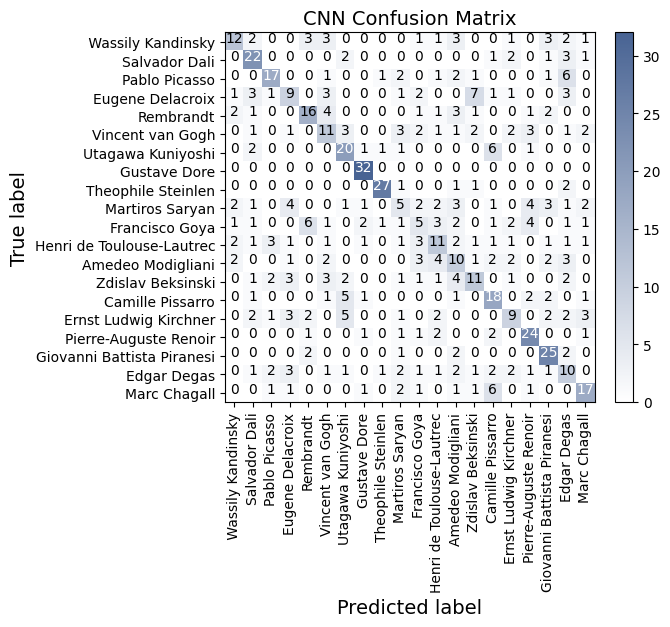

In [16]:
# A depiction of the Confusion Matrix
matplotlib.rc_file_defaults() # to remove the sns darkgrid style
cfmatrix = confusion_matrix(y_true, y_pred)
plot_cm(cfmatrix,'CNN Confusion Matrix',artists)

### Part C: Transfer learning

While the first attempt was a good one, we may also utilize transfer learning methods, by using powerful pre-trained CNNs from [here](https://pytorch.org/vision/stable/models.html).

#### ResNet

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Initiating CNN training.
[1/2500] Training loss: 3.3304	 Validation loss: 1.8103.
[2/2500] Training loss: 1.2074	 Validation loss: 1.1919.
[3/2500] Training loss: 0.6573	 Validation loss: 1.0446.
[4/2500] Training loss: 0.3634	 Validation loss: 0.9085.
[5/2500] Training loss: 0.1966	 Validation loss: 0.8728.
[6/2500] Training loss: 0.1103	 Validation loss: 0.8441.
[7/2500] Training loss: 0.0710	 Validation loss: 0.8240.
[8/2500] Training loss: 0.0537	 Validation loss: 0.8239.
Validation loss increase spotted. Early stopping counter: 1 out of 10
[9/2500] Training loss: 0.0400	 Validation loss: 0.8359.
[10/2500] Training loss: 0.0328	 Validation loss: 0.8120.
[11/2500] Training loss: 0.0272	 Validation loss: 0.8060.
[12/2500] Training loss: 0.0208	 Validation loss: 0.7957.
Validation loss increase spotted. Early stopping counter: 1 out of 10
[13/2500] Training loss: 0.0161	 Validation loss: 0.8070.
Validation loss increase spotted. Early stopping counter: 2 out of 10
[14/2500] Training l

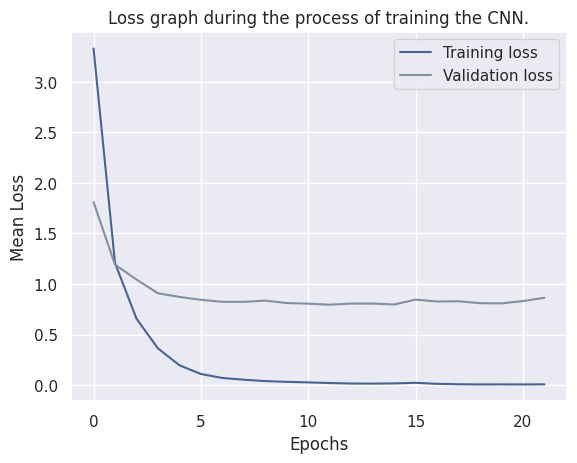

              precision    recall  f1-score   support

           0       0.81      0.81      0.81        32
           1       1.00      0.94      0.97        32
           2       0.77      0.75      0.76        32
           3       0.75      0.66      0.70        32
           4       0.74      0.78      0.76        32
           5       0.86      0.73      0.79        33
           6       0.79      0.81      0.80        32
           7       0.91      1.00      0.96        32
           8       1.00      0.94      0.97        32
           9       0.49      0.59      0.54        32
          10       0.81      0.66      0.72        32
          11       0.74      0.81      0.78        32
          12       0.71      0.69      0.70        32
          13       0.74      0.81      0.78        32
          14       0.77      0.84      0.81        32
          15       0.63      0.53      0.58        32
          16       0.79      0.82      0.81        33
          17       0.84    

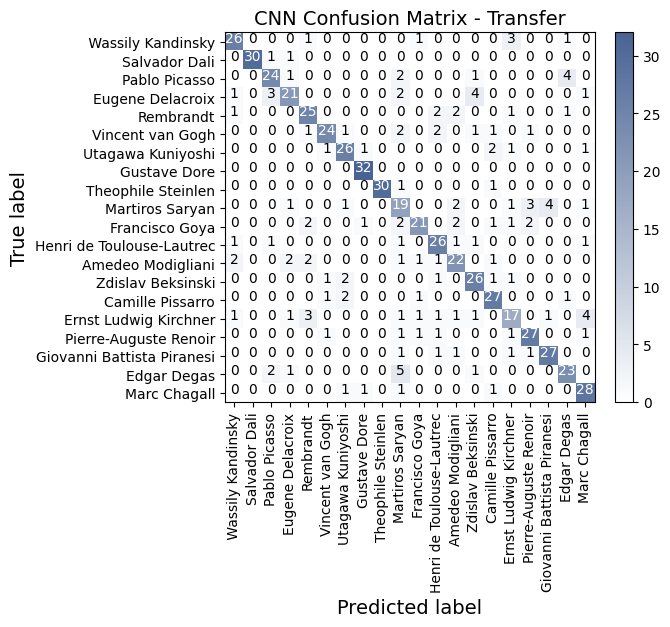

CPU times: user 2min 7s, sys: 1.63 s, total: 2min 9s
Wall time: 2min 10s


In [17]:
%%time
learning_rate = 0.00005
weight_decay = 1e-6
patience = 10
verbose_ct = 1

epochs = 2500

model_conv = models.resnet18(pretrained=True)
#for param in model_conv.parameters():
#    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 256)
model_conv.fc2 = nn.Linear(256,20)
model_conv.sfact = nn.Softmax(1)

model_conv = model_conv.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_conv.parameters(), lr = learning_rate, weight_decay = weight_decay)

# Train the model
t_losses, v_losses = train(model_conv, train_loader, val_loader, optimizer, epochs,
                           device=device, patience=patience, verbose_ct = verbose_ct)

sns.set(style = "darkgrid")

# Plot the loss diagram
plot_losses(t_losses, v_losses, 'CNN_Training_Loss_transfer.pdf')

torch.save(model_conv.state_dict(), 'ResNet-Trained.pt')

# Evaluate the model
predictions, labels = evaluate(model_conv, test_loader, device=device)

y_true = np.concatenate(labels, axis=0)
y_pred = np.concatenate(predictions, axis=0)

print(classification_report(y_true, y_pred))

# A depiction of the Confusion Matrix
matplotlib.rc_file_defaults() # to remove the sns darkgrid style
cfmatrix = confusion_matrix(y_true, y_pred)
plot_cm(cfmatrix,'CNN Confusion Matrix - Transfer',artists)

### Part D: Classic Classifiers

While somewhat unorthodox, since we usually start with the less efficient classifiers, we close this study by training "classic" classifiers to identify painters. The classifiers used are:

- An SVM Classifier trained on HOG features extracted from the images.

- An SVM & k-Means hybrid trained on SIFT features extracted from the images in a Bag-of-Words approximation.

#### Case 1: HOG

In [18]:
%%time
# Load the Dataset for classic training - HOG
hog_data = ImageData(file_path, active_df, LabEnc, hog_mode=[9, (8,8), (2,2)], sift_mode=False, img_size=224)

Skipped loading image 95010.jpg to avoid a DecompressionBombError.
CPU times: user 4min 44s, sys: 5.61 s, total: 4min 49s
Wall time: 6min 45s


In [19]:
# Split the data - no validation set needed, unless we want to perform hyperparameter tuning
X_train, X_test, y_train, y_test = DataSplitter(hog_data, ratios=[85,5,10], need_val=False, batches=32, shuffle=True, seed=420)

In [20]:
%%time
# Train the SVM on the hog features
hog_classifier = svm.SVC(kernel='rbf', gamma=1.5, C=0.3)
hog_classifier.fit(X_train, y_train)

CPU times: user 15min 43s, sys: 2.13 s, total: 15min 45s
Wall time: 15min 56s


SVC(C=0.3, gamma=1.5)

In [21]:
# Draw predictions and evaluate the HOG classifier
y_pred = hog_classifier.predict(X_test)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.12      0.09      0.11        32
           1       0.00      0.00      0.00        32
           2       0.14      0.62      0.22        32
           3       0.02      0.03      0.03        32
           4       0.00      0.00      0.00        32
           5       0.10      0.09      0.10        32
           6       0.29      0.41      0.34        32
           7       0.61      0.84      0.71        32
           8       0.34      0.78      0.47        32
           9       0.00      0.00      0.00        33
          10       0.75      0.19      0.30        32
          11       0.00      0.00      0.00        32
          12       0.06      0.12      0.08        32
          13       0.18      0.19      0.18        32
          14       0.00      0.00      0.00        32
          15       0.10      0.19      0.13        32
          16       0.33      0.28      0.31        32
          17       1.00    

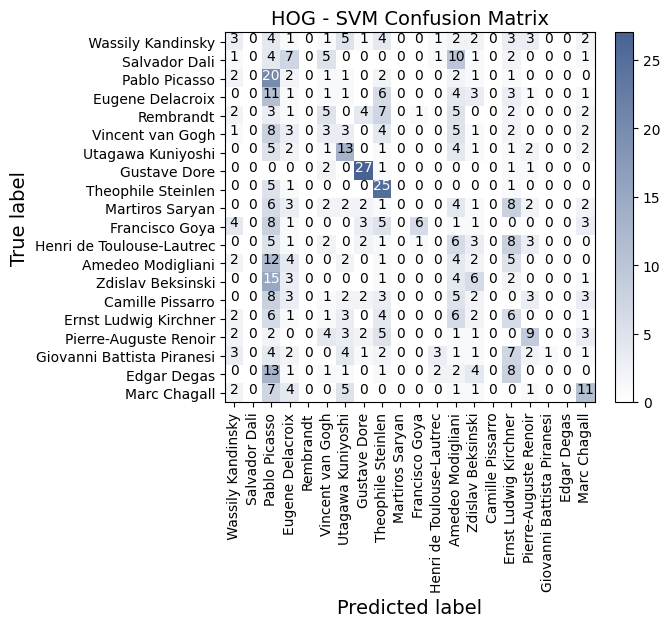

In [22]:
matplotlib.rc_file_defaults() # to remove the sns darkgrid style
print(classification_report(y_test, y_pred))

# A depiction of the Confusion Matrix
cfmatrix = confusion_matrix(y_test, y_pred)
plot_cm(cfmatrix,'HOG - SVM Confusion Matrix',artists)

#### Case 2: SIFT

In [23]:
%%time
# Load the Dataset for classic training
sift_data = ImageData(file_path, active_df, LabEnc, hog_mode=False, sift_mode=True, img_size=224)

Skipped loading image 95010.jpg to avoid a DecompressionBombError.
CPU times: user 2min 30s, sys: 12.7 s, total: 2min 42s
Wall time: 3min 49s


In [24]:
# Split the data - no validation set needed, unless we want to perform hyperparameter tuning
X_train_s, X_test_s, y_train_s, y_test_s = DataSplitter(sift_data, ratios=[85,5,10], need_val=False, batches=32, shuffle=True, seed=420)

As of this point we have the full dataset in the form of grayscale images from the SIFT procedure and the data split has already been performed. The pipeline to create a classifier is the following:

- For each image in the train set, we acquire all of its descriptors ((X,128) array per image) and then stack all the descriptors together. This leads to a lengthy list of features (descriptors).

- Due to the large number of features (descriptors) we perform k-Means clustering on the points created on the 128-dimensional space to reduce the dimension of our features to $k$, where $k$ is the number of clusters to be considered. It's common practice to use $k$ = `unique_labels` x `a`, where a is an integer (for example a = 10).

- Having acquired the cluster's centroids, we re-visit the descriptors of every image. For every image, we calculate a histogram, which is a (1,k) shaped array with contribution elements, $t_i$, where $0 < t_i < 1$, $i \in \{0,\dots,k\}$. These contribution elements are acquired by applying the k-Means classifier on the image's descriptors.

- A classifier (for example an SVM) is trained using the constructed histograms as features. In order to classify new data, the process of extracting descriptors and classifying them using the k-Means classifier needs to be repeated.

In [25]:
%%time
# Draw all descriptors
Descriptors = []
for image in X_train_s:
    sift = cv2.xfeatures2d.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    Descriptors.append(descriptors)

[ WARN:0] global /tmp/pip-req-build-21t5esfk/opencv_contrib/modules/xfeatures2d/misc/python/shadow_sift.hpp (13) SIFT_create DEPRECATED: cv.xfeatures2d.SIFT_create() is deprecated due SIFT tranfer to the main repository. https://github.com/opencv/opencv/issues/16736


CPU times: user 1min 50s, sys: 3.22 s, total: 1min 53s
Wall time: 1min 10s


In [26]:
%%time
# Perform the clustering
features = np.vstack(Descriptors) # List of features to perform the clustering

k = 500 # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(features)

CPU times: user 3h 59min 59s, sys: 26min 16s, total: 4h 26min 15s
Wall time: 2h 25min 27s


KMeans(n_clusters=500, random_state=0)

In [27]:
%%time
# We now have k centroids
bag_of_histograms = []

for descriptor_list in Descriptors:
    histogram = np.zeros(k)
    desc_length = descriptor_list.shape[0]
    
    for desc in descriptor_list:
        idx = kmeans.predict(np.array(desc).reshape(1, -1))
        histogram[idx] += 1/desc_length # for normalization
        
    bag_of_histograms.append(histogram)

X_train_new = np.asarray(bag_of_histograms)

CPU times: user 5min 54s, sys: 50.5 s, total: 6min 44s
Wall time: 6min 45s


In [28]:
%%time
# Transform the test data so that they can be classified
test_histograms = []

for image in X_test_s:
    sift = cv2.xfeatures2d.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    
    histogram = np.zeros(k)
    desc_length = descriptors.shape[0]
    
    for desc in descriptors:
        idx = kmeans.predict(np.array(desc).reshape(1, -1))
        histogram[idx] += 1/desc_length
        
    test_histograms.append(histogram)
    
X_test_new = np.asarray(test_histograms)

CPU times: user 1min 20s, sys: 9.65 s, total: 1min 29s
Wall time: 1min 22s


In [29]:
%%time
# Train the classifier on the new X_train
sift_classifier = svm.SVC(kernel='rbf', gamma=6.1, C=8.3)
sift_classifier.fit(X_train_new, y_train_s)

CPU times: user 12.6 s, sys: 10.3 ms, total: 12.6 s
Wall time: 12.6 s


SVC(C=8.3, gamma=6.1)

              precision    recall  f1-score   support

           0       0.35      0.25      0.29        32
           1       0.51      0.59      0.55        32
           2       0.39      0.69      0.49        32
           3       0.22      0.25      0.24        32
           4       0.38      0.56      0.46        32
           5       0.18      0.19      0.18        32
           6       0.25      0.25      0.25        32
           7       0.44      0.53      0.48        32
           8       0.39      0.62      0.48        32
           9       0.14      0.09      0.11        33
          10       0.38      0.28      0.32        32
          11       0.18      0.12      0.15        32
          12       0.16      0.09      0.12        32
          13       0.29      0.53      0.38        32
          14       0.50      0.22      0.30        32
          15       0.00      0.00      0.00        32
          16       0.29      0.31      0.30        32
          17       0.48    

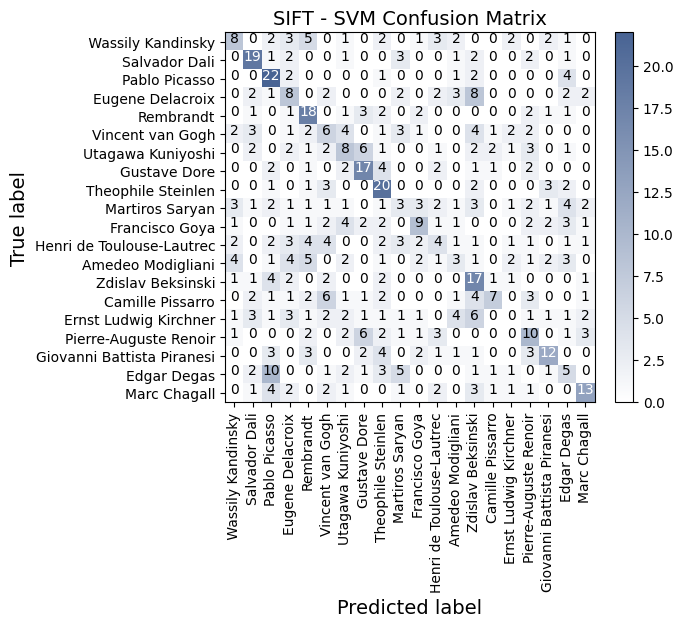

In [30]:
# Perform the classification and draw predictions
y_pred_s = sift_classifier.predict(X_test_new)

print(classification_report(y_test_s, y_pred_s))

# A depiction of the Confusion Matrix
cfmatrix_s = confusion_matrix(y_test_s, y_pred_s)
plot_cm(cfmatrix_s,'SIFT - SVM Confusion Matrix',artists)